In [1]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder_path):
    images = []
    labels = []
    class_names = os.listdir(folder_path)

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    # Resize the image to a consistent size (if needed)
                    img = cv2.resize(img, (224, 224))
                    # Normalize pixel values (optional but recommended)
                    img = img / 255.0
                    images.append(img)
                    labels.append(class_name)

    return np.array(images), np.array(labels)

# Replace 'path/to/your/dataset' with the path to your dataset
dataset_path = 'FaceImages'

# Load images from the dataset folder
images, labels = load_images_from_folder(dataset_path)

# Perform any additional preprocessing or splitting into train/test sets as needed
# ...

# Print the shape of the loaded dataset
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (4424, 224, 224, 3)
Labels shape: (4424,)


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4424 files belonging to 12 classes.
Using 3540 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4424 files belonging to 12 classes.
Using 884 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Faces', 'Faces1', 'Faces10', 'Faces11', 'Faces2', 'Faces3', 'Faces4', 'Faces5', 'Faces6', 'Faces7', 'Faces8', 'Faces9']


In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
111/111 [==============================] - 18s 158ms/step - loss: 0.3147 - accuracy: 0.9068 - val_loss: 0.0088 - val_accuracy: 0.9955
Epoch 2/10
111/111 [==============================] - 18s 157ms/step - loss: 0.0108 - accuracy: 0.9980 - val_loss: 0.0027 - val_accuracy: 0.9989
Epoch 3/10
111/111 [==============================] - 18s 159ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0039 - val_accuracy: 0.9989
Epoch 4/10
111/111 [==============================] - 18s 156ms/step - loss: 0.0023 - accuracy: 0.9989 - val_loss: 8.3051e-05 - val_accuracy: 1.0000
Epoch 5/10
111/111 [==============================] - 18s 158ms/step - loss: 6.3086e-04 - accuracy: 0.9997 - val_loss: 5.7528e-04 - val_accuracy: 1.0000
Epoch 6/10
111/111 [==============================] - 18s 162ms/step - loss: 6.3209e-05 - accuracy: 1.0000 - val_loss: 3.7098e-05 - val_accuracy: 1.0000
Epoch 7/10
111/111 [==============================] - 19s 166ms/step - loss: 8.8004e-06 - accuracy: 1.0000 - v

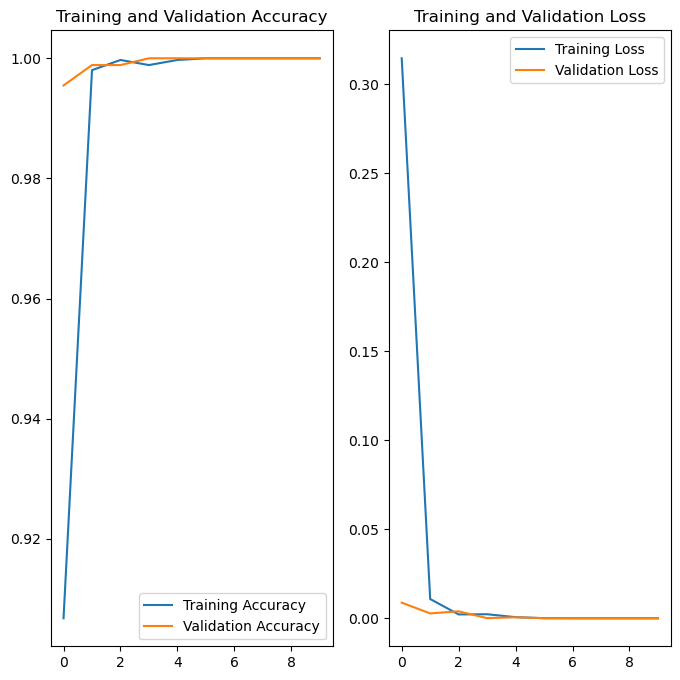

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

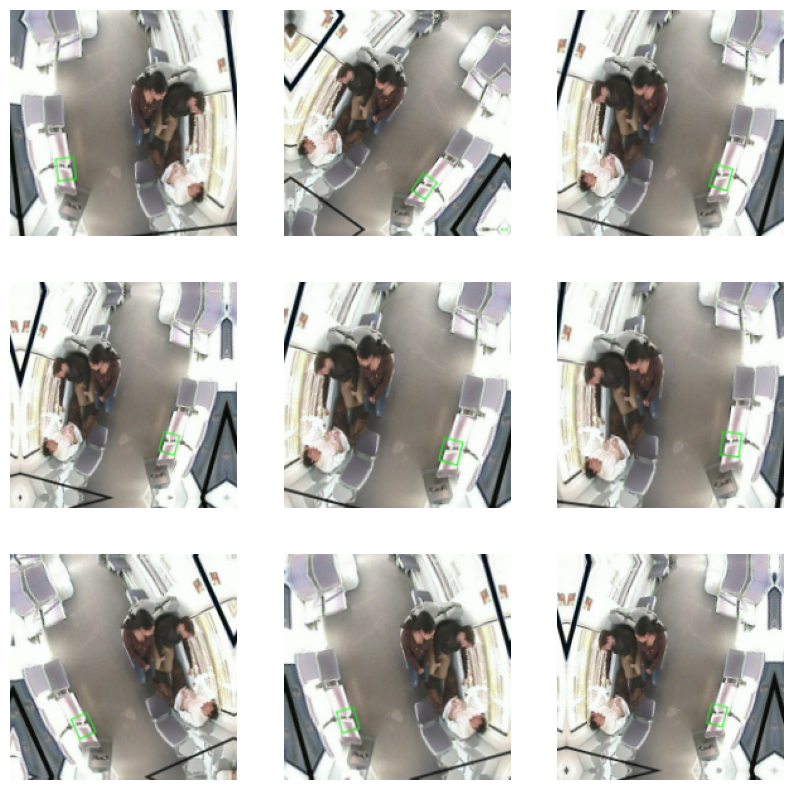

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

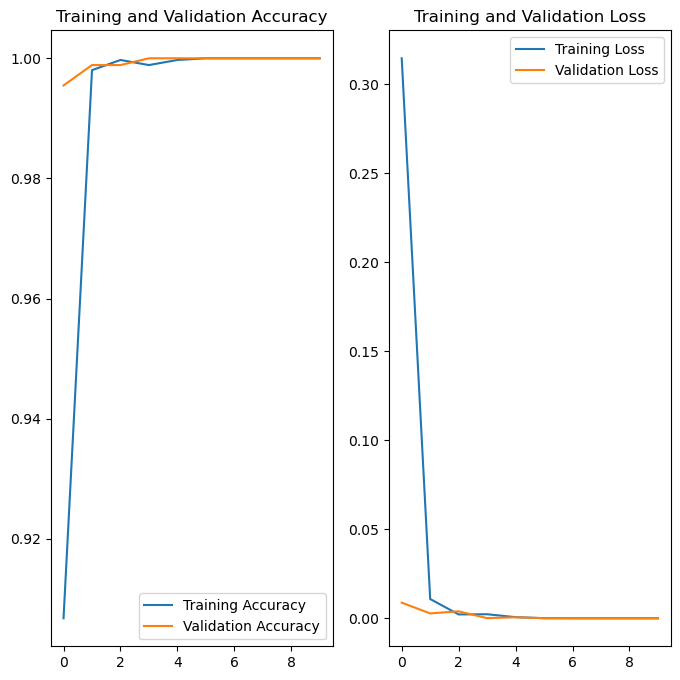

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [3]:
import os

def remove_ds_store(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")

# Replace 'path/to/your/directory' with the path to the directory containing '.DS_Store' files
directory_path = 'Subset/train'
remove_ds_store(directory_path)


Removed: Subset/train/.DS_Store


In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('Subset/train')

label_types = os.listdir('Subset/train')
print (label_types)  

['Walking', 'Fighting', 'Sitting', 'LayingDown']


In [5]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('Subset/train' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('Subset/train' + '/' +item) + '/' + room))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(train_df.head())
print(train_df.tail())

       tag                                    video_name
0  Walking         Subset/train/Walking/Disease.Cam2.mp4
1  Walking         Subset/train/Walking/Disease.Cam3.mp4
2  Walking         Subset/train/Walking/Disease.Cam5.mp4
3  Walking         Subset/train/Walking/Disease.Cam7.mp4
4  Walking  Subset/train/Walking/Disease_Public.Cam8.mp4
           tag                                         video_name
73  LayingDown  Subset/train/LayingDown/Newspaper_French.Cam2.mp4
74  LayingDown  Subset/train/LayingDown/Newspaper_French.Cam7.mp4
75  LayingDown  Subset/train/LayingDown/Newspaper_French.Cam5.mp4
76  LayingDown  Subset/train/LayingDown/Newspaper_French.Cam4.mp4
77  LayingDown           Subset/train/LayingDown/Disease.Cam9.mp4


In [6]:
df = train_df.loc[:,['video_name','tag']]
df
df.to_csv('train.csv')

In [8]:
import os

def remove_ds_store(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")

# Replace 'path/to/your/directory' with the path to the directory containing '.DS_Store' files
directory_path = 'Subset/test'
remove_ds_store(directory_path)

Removed: Subset/test/.DS_Store


In [9]:
dataset_path = os.listdir('Subset/test')
print(dataset_path)

room_types = os.listdir('Subset/test')
print("Types of activities found: ", len(dataset_path))

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('Subset/test' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('Subset/test' + '/' +item) + '/' + room))
    
# Build a dataframe        
test_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(test_df.head())
print(test_df.tail())

df = test_df.loc[:,['video_name','tag']]
df
df.to_csv('test.csv')

['Walking', 'Fighting', 'Sitting', 'LayingDown']
Types of activities found:  4
       tag                                   video_name
0  Walking         Subset/test/Walking/Disease.Cam1.mp4
1  Walking         Subset/test/Walking/Faces_6.Cam1.mp4
2  Walking         Subset/test/Walking/Disease.Cam4.mp4
3  Walking  Subset/test/Walking/Disease_Public.Cam9.mp4
4  Walking         Subset/test/Walking/Faces_5.Cam1.mp4
           tag                                         video_name
23  LayingDown   Subset/test/LayingDown/Newspaper_French.Cam9.mp4
24  LayingDown  Subset/test/LayingDown/Newspaper_Spanish.Cam1.mp4
25  LayingDown  Subset/test/LayingDown/Newspaper_Spanish.Cam3.mp4
26  LayingDown  Subset/test/LayingDown/Newspaper_Spanish.Cam5.mp4
27  LayingDown            Subset/test/LayingDown/Disease.Cam8.mp4


In [10]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [12]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")


train_df.sample(10)

Total videos for training: 78
Total videos for testing: 28


,Unnamed: 0,video_name,tag
74,74,Subset/train/LayingDown/Newspaper_French.Cam7.mp4,LayingDown
35,35,Subset/train/Fighting/Checkout_French.Cam2.mp4,Fighting
48,48,Subset/train/Sitting/Panic.Cam7.mp4,Sitting
55,55,Subset/train/Sitting/No_Event.Cam3.mp4,Sitting
63,63,Subset/train/LayingDown/Disease.Cam5.mp4,LayingDown
38,38,Subset/train/Fighting/Harass_Spanish.Cam3.mp4,Fighting
29,29,Subset/train/Fighting/Cell_phone_Spanish.Cam3.mp4,Fighting
4,4,Subset/train/Walking/Disease_Public.Cam8.mp4,Walking
54,54,Subset/train/Sitting/Checkout_French.Cam5.mp4,Sitting
39,39,Subset/train/Fighting/Harass_French.Cam5.mp4,Fighting


In [13]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
IMG_SIZE = 224


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [14]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [15]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
#print(label_processor.get_vocabulary())

labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy()
labels

array([[3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [16]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [17]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    
    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["tag"].values
    
    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") # 145,20
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #145,20,2048

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")



print(f"train_labels in train set: {train_labels.shape}")

print(f"test_labels in train set: {test_labels.shape}")

# MAX_SEQ_LENGTH = 20, NUM_FEATUR

Frame features in train set: (78, 20, 2048)
Frame masks in train set: (78, 20)
train_labels in train set: (78, 1)
test_labels in train set: (28, 1)


OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Disease.Cam2.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Disease.Cam3.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Disease.Cam5.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Disease.Cam7.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Disease_Public.Cam8.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Faces_6.Cam10.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Disease.Cam6.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Faces_1.Cam10.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Faces_1.Cam1.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Faces_2.Cam10.mp4"
OpenCV: Couldn't read video stream from file "train/Subset/train/Walking/Faces_4

In [18]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

EPOCHS = 30
# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/30
1/2 [==============>...............] - ETA: 1s - loss: 1.3863 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 1.38824, saving model to ./tmp/video_classifier
2/2 [==============================] - 2s 615ms/step - loss: 1.3860 - accuracy: 0.5000 - val_loss: 1.3882 - val_accuracy: 0.0000e+00
Epoch 2/30
1/2 [==============>...............] - ETA: 0s - loss: 1.3847 - accuracy: 0.5938
Epoch 2: val_loss did not improve from 1.38824
2/2 [==============================] - 0s 27ms/step - loss: 1.3847 - accuracy: 0.5000 - val_loss: 1.3901 - val_accuracy: 0.0000e+00
Epoch 3/30
1/2 [==============>...............] - ETA: 0s - loss: 1.3834 - accuracy: 0.4375
Epoch 3: val_loss did not improve from 1.38824
2/2 [==============================] - 0s 23ms/step - loss: 1.3833 - accuracy: 0.5000 - val_loss: 1.3920 - val_accuracy: 0.0000e+00
Epoch 4/30
1/2 [==============>...............] - ETA: 0s - loss: 1.3817 - accuracy: 0.5000
Epoch 4: val_loss did not improve from 1.38824
2/2 [==

In [19]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)

Test video path: Subset/test/Fighting/Harass_French.Cam6.mp4


OpenCV: Couldn't read video stream from file "test/Subset/test/Fighting/Harass_French.Cam6.mp4"


1/1 [==============================] - 1s 555ms/step
  Fighting: 25.05%
  Walking: 25.05%
  Sitting: 24.95%
  LayingDown: 24.95%
